In [ ]:
!pip install seaborn

ToDo: Look into factor analysis

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, preprocessing, pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('../../data/raw/sdBShortP_large_BPS_set.csv')

# Data preparation

In [ ]:
# extract the alpha value from the ce_parameters (alpha_ce is always the same as alpha_th)
df['alpha_ce'] = df['ce_parameters'].apply(lambda x: eval(x)['a_ce'])

In [ ]:
# Mark systems with a He ignition or burning error as error. ignore other errors.
df['error'] = df['error_flags'].apply(lambda x: 1 if 4 in eval(x) or 5 in eval(x) else 0)

In [ ]:
# remove systems that merge or are contact systems (the latter are likely also mergers)
df = df[(df['stability'] != 'merger') & (df['stability'] != 'contact')]

In [ ]:
df['product'] = 'UK'

for i, line in df.iterrows():
    
    sdA = line['sdA']
    sdB = line['sdB']
    sdO = line['sdO']
    HeBurn = line['HeCoreBurning']
    HeWD = line['He-WD']
    
    product = 'failed'
    if line['stability'] == 'CE' or line['stability'] == 'merger' or line['stability'] == 'contact':
        product = 'UK'
    elif sdA:
        product = 'sdA'
    elif sdB:
        product = 'sdB'
    elif sdO:
        product = 'sdO'
    elif HeWD:
        product = 'He-WD'
    elif HeBurn:
        product = 'HB'
    
    df.loc[i, 'product'] = product

In [ ]:
df['stability'].value_counts()

stable    6387
CE        3276
Name: stability, dtype: int64

In [ ]:
df_ce =df[df['stability'] == 'CE']
df_stable = df[(df['stability'] == 'stable') & (df['error'] == 0)]
df_he = df_stable[df_stable['HeCoreBurning'] == 1]

# Regression Model

In [ ]:
X_features = ['M1_init', 'FeH_init', 'M1env_MLend', 'M1core_MLend']
y_features = 'HeCoreBurning'

In [ ]:
df_select = df_stable[~df_stable[X_features].isna().any(axis=1)]
df_select[y_features] = df_select[y_features].apply(lambda x: 1 if x else 0)

In [ ]:
data_X = df_select[X_features]
data_y = df_select[y_features]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20)

In [ ]:
# The pipeline is constructed a bit strangely with an unnecessary columntransformer, but this is necessary later
# on when testing different parameter combinations with a CV grid search
scaler = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), X_features),
    ]
)
pipe = pipeline.Pipeline([('scaler', scaler), 
                          ('poly', preprocessing.PolynomialFeatures(2, interaction_only=False)),
                          ('clf', linear_model.LogisticRegression())])

In [ ]:
pipe.fit(train_X, train_y)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['M1_init', 'FeH_init',
                                                   'M1env_MLend',
                                                   'M1core_MLend'])])),
                ('poly', PolynomialFeatures()), ('clf', LogisticRegression())])

In [ ]:
print('Accuracy:')
print('Training score: ', pipe.score(train_X, train_y))
print('Test score: ', pipe.score(test_X, test_y))

Accuracy:
Training score:  0.9782608695652174
Test score:  0.9747826086956521


## Check which parameters are the most important

In [ ]:
def get_name(powers, feature_names):
    
    name = ""
    for p, f in zip(powers, feature_names):
        if p > 0:
            if name != "":
                name += " * "
            if p > 1:
                name += str(f) + '^' + str(p)
            else:
                name += str(f)
    
    if name == "":
        name = 'bias'
            
    return name
    

def print_coef(pipe, feature_names):
    powers_ = pipe['poly'].powers_
    coef_ = pipe['clf'].coef_

    if 'scaler' in pipe:
        pars_ = pipe['scaler'].transformers_[0][2]
        mean_ = pipe['scaler'].transformers_[0][1].mean_
        var_ = pipe['scaler'].transformers_[0][1].var_

        for p, m, v in zip(pars_, mean_, var_):
            print("{:15s} : mean = {:+0.3f} var = {:0.3f}".format(p, m, v))
        
        print()

    for p, c in zip(powers_, coef_[0]):
        
        feature = get_name(p, feature_names)
        print("{:30s} : {:+0.3f}".format(feature, c))

In [ ]:
print_coef(pipe, X_features)

bias                           : -0.258
M1_init                        : -12.740
FeH_init                       : -0.231
M1env_MLend                    : +0.864
M1core_MLend                   : +13.395
M1_init^2                      : +3.731
M1_init * FeH_init             : -0.025
M1_init * M1env_MLend          : +2.828
M1_init * M1core_MLend         : +10.241
FeH_init^2                     : -0.751
FeH_init * M1env_MLend         : -1.414
FeH_init * M1core_MLend        : -1.484
M1env_MLend^2                  : -3.182
M1env_MLend * M1core_MLend     : +2.977
M1core_MLend^2                 : +11.657


## Check feature importance

In [ ]:
import itertools
all_combinations = []
for r in range(1, len(X_features) + 1):
    combinations_list = list(itertools.combinations(X_features, r))
    all_combinations += combinations_list

transformers = []
for comb in all_combinations:
    transformers.append([('num', preprocessing.StandardScaler(), list(comb) )])

search_space = [{'scaler__transformers': transformers}]

[{'scaler__transformers': [[('num', StandardScaler(), ['M1_init'])], [('num', StandardScaler(), ['FeH_init'])], [('num', StandardScaler(), ['M1env_MLend'])], [('num', StandardScaler(), ['M1core_MLend'])], [('num', StandardScaler(), ['M1_init', 'FeH_init'])], [('num', StandardScaler(), ['M1_init', 'M1env_MLend'])], [('num', StandardScaler(), ['M1_init', 'M1core_MLend'])], [('num', StandardScaler(), ['FeH_init', 'M1env_MLend'])], [('num', StandardScaler(), ['FeH_init', 'M1core_MLend'])], [('num', StandardScaler(), ['M1env_MLend', 'M1core_MLend'])], [('num', StandardScaler(), ['M1_init', 'FeH_init', 'M1env_MLend'])], [('num', StandardScaler(), ['M1_init', 'FeH_init', 'M1core_MLend'])], [('num', StandardScaler(), ['M1_init', 'M1env_MLend', 'M1core_MLend'])], [('num', StandardScaler(), ['FeH_init', 'M1env_MLend', 'M1core_MLend'])], [('num', StandardScaler(), ['M1_init', 'FeH_init', 'M1env_MLend', 'M1core_MLend'])]]}]


In [ ]:
gscv = GridSearchCV(pipe, search_space, cv=5, verbose=1)
_ = gscv.fit(data_X, data_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.5s finished


In [ ]:
parameters, scores = [], []
for pars, score in zip(gscv.cv_results_['params'], gscv.cv_results_['mean_test_score']):
    parameters.append(pars['scaler__transformers'][0][2])
    scores.append(score)

results = pd.DataFrame(data={'accuracy': scores, 'parameters': parameters})

results.sort_values(by='accuracy', ascending=False, inplace=True)

print(results)

    accuracy                                      parameters
14  0.976696  [M1_init, FeH_init, M1env_MLend, M1core_MLend]
12  0.967130            [M1_init, M1env_MLend, M1core_MLend]
11  0.958435               [M1_init, FeH_init, M1core_MLend]
6   0.944870                         [M1_init, M1core_MLend]
9   0.856348                     [M1env_MLend, M1core_MLend]
13  0.854261           [FeH_init, M1env_MLend, M1core_MLend]
2   0.729043                                   [M1env_MLend]
7   0.710087                         [FeH_init, M1env_MLend]
10  0.681043                [M1_init, FeH_init, M1env_MLend]
8   0.678609                        [FeH_init, M1core_MLend]
5   0.678261                          [M1_init, M1env_MLend]
3   0.667652                                  [M1core_MLend]
1   0.601565                                      [FeH_init]
4   0.566087                             [M1_init, FeH_init]
0   0.564522                                       [M1_init]


The importance of a parameter can be determined by looking at all models that include that parameter and compare those with the models that do 
not include that paramaters. by taking the average of all differences we can then order the parameters by importance. The higher the resulting 
number, the more important the parameter is.

In [ ]:
parameter_importance = {p: [] for p in X_features}

for parameter in X_features:
    for i, line in results.iterrows():
        if parameter in line['parameters']:
            baseline = line['accuracy']
            l_c = line['parameters'].copy()
            l_c.remove(parameter)

            selection = results['parameters'].apply(lambda x: len(x) == len(l_c) and x == l_c)

            new = results[selection]['accuracy'].values

            if len(new) > 0:
                parameter_importance[parameter].append(baseline - new[0])

        else:
            continue

for parameter, diff in parameter_importance.items():
    print(parameter, np.average(diff))

M1_init 0.09642236024844718
FeH_init 0.0024844720496894268
M1env_MLend 0.10601242236024845
M1core_MLend 0.24367701863354047


## Check error in function of feature values

In [ ]:
prob = pipe.predict_proba(data_X)
pred = pipe.predict(data_X)

In [ ]:
data_pred = data_X.copy()
data_pred['ignition'] = data_y.values
data_pred['prediction'] = pred
data_pred['probability'] = prob.max(axis=1)
data_pred['error'] = 1 - abs(pred - data_y.values)
data_pred.sort_values(by='probability', inplace=True, ascending=False)

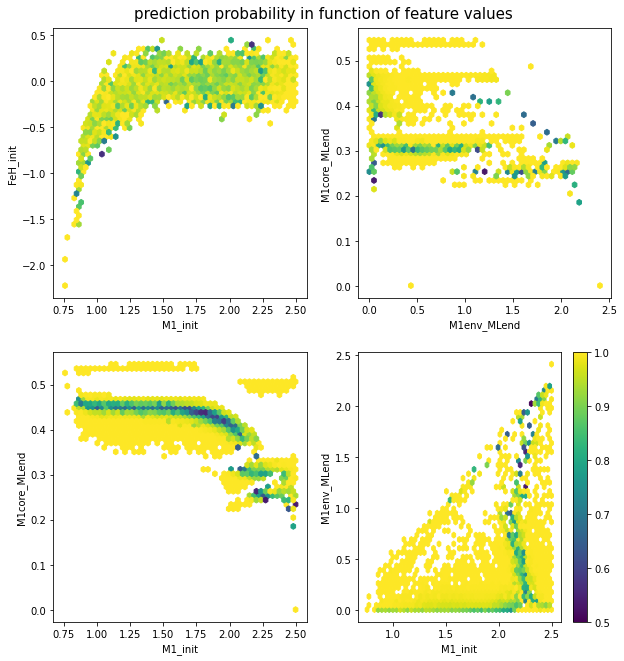

In [ ]:
fig = pl.figure(figsize=(10, 10))

fig.suptitle('prediction probability in function of feature values', fontsize=15)

pl.subplots_adjust(top=0.95)

pl.subplot(221)
pl.hexbin(data_pred['M1_init'], data_pred['FeH_init'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('FeH_init')

pl.subplot(222)
pl.hexbin(data_pred['M1env_MLend'], data_pred['M1core_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1env_MLend')
pl.ylabel('M1core_MLend')

pl.subplot(223)
pl.hexbin(data_pred['M1_init'], data_pred['M1core_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1core_MLend')

pl.subplot(224)

pl.hexbin(data_pred['M1_init'], data_pred['M1env_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1env_MLend')
pl.colorbar()

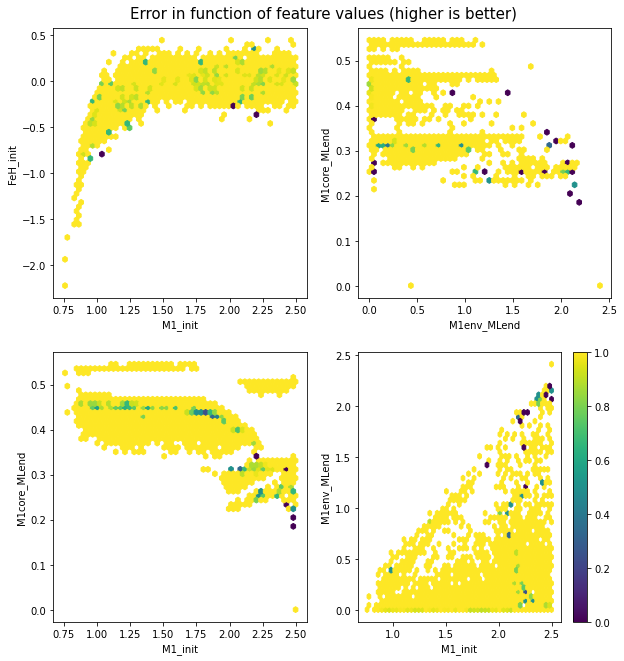

In [ ]:
fig = pl.figure(figsize=(10, 10))

fig.suptitle('Error in function of feature values (higher is better)', fontsize=15)

pl.subplots_adjust(top=0.95)

pl.subplot(221)
pl.hexbin(data_pred['M1_init'], data_pred['FeH_init'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('FeH_init')

pl.subplot(222)
pl.hexbin(data_pred['M1env_MLend'], data_pred['M1core_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1env_MLend')
pl.ylabel('M1core_MLend')

pl.subplot(223)
pl.hexbin(data_pred['M1_init'], data_pred['M1core_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1core_MLend')

pl.subplot(224)

pl.hexbin(data_pred['M1_init'], data_pred['M1env_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1env_MLend')
pl.colorbar()